<a href="https://colab.research.google.com/github/Sameersah/decision-trees-ensemble/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest

Key Components:

- Custom Random Forest implementation for both classification and regression
- Bootstrap sampling
- Random feature selection
- Feature importance calculation
- Demonstration on synthetic datasets
- Comparison with scikit-learn implementation
- Performance metrics and visualizations

The implementation includes:

- Base class for Random Forest
- Separate implementations for Classification and Regression
- Bootstrapping and feature selection mechanics
- Feature importance tracking


--- CLASSIFICATION DEMONSTRATION ---
Custom Random Forest Classification Performance:
Accuracy: 0.84

Scikit-learn Random Forest Classification Performance:
Accuracy: 0.865


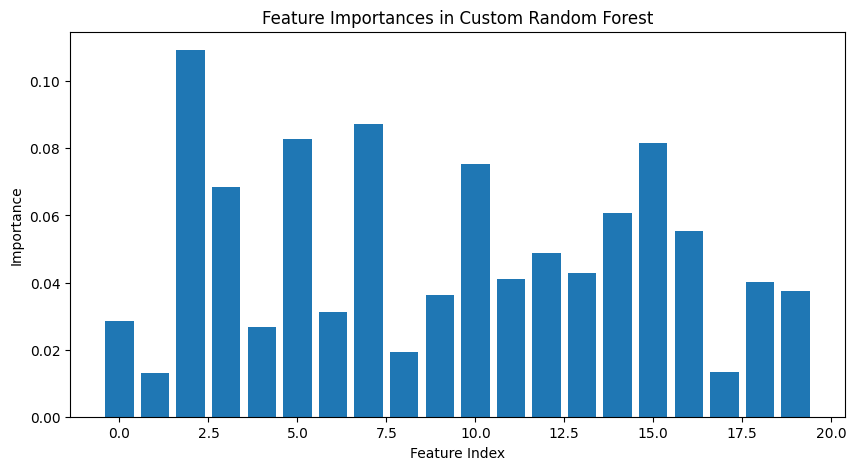


--- REGRESSION DEMONSTRATION ---
Custom Random Forest Regression Performance:
MSE: 10002.616712006813
R2 Score: 0.741592512207842

Scikit-learn Random Forest Regression Performance:
MSE: 10226.703516434598
R2 Score: 0.7358034562191176


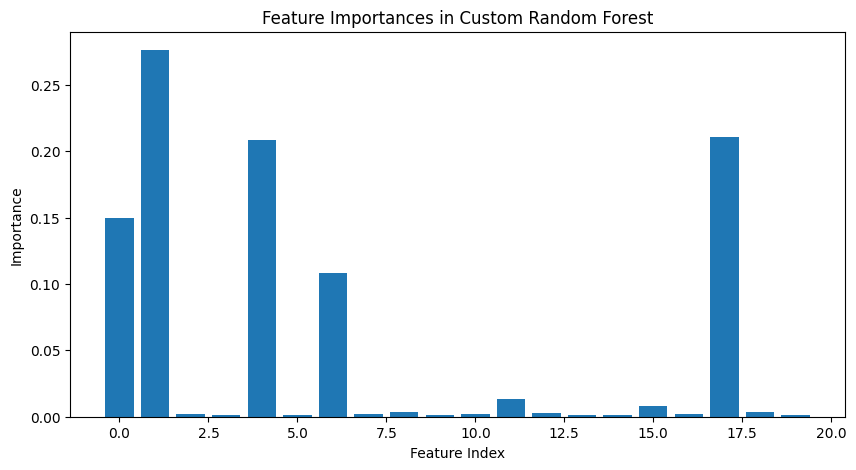

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

class RandomForestBase:
    def __init__(self,
                 n_estimators=100,
                 max_depth=None,
                 min_samples_split=2,
                 task='classification'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task = task
        self.trees = []
        self.feature_importances_ = None

    def _bootstrap_sample(self, X, y):
        """
        Create bootstrap sample of the dataset
        """
        n_samples = X.shape[0]
        indices = np.random.randint(0, n_samples, n_samples)
        return X[indices], y[indices]

    def _select_features(self, X):
        """
        Randomly select subset of features
        """
        n_features = X.shape[1]
        # For classification, sqrt(n_features), for regression, n_features
        if self.task == 'classification':
            n_selected = int(np.sqrt(n_features))
        else:
            n_selected = n_features

        return np.random.choice(
            range(n_features),
            size=n_selected,
            replace=False
        )

class RandomForestClassifier(RandomForestBase):
    def __init__(self,
                 n_estimators=100,
                 max_depth=None,
                 min_samples_split=2):
        super().__init__(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            task='classification'
        )

    def fit(self, X, y):
        # Reset trees for each fit
        self.trees = []
        self.feature_importances_ = np.zeros(X.shape[1])

        # Create forest of trees
        for _ in range(self.n_estimators):
            # Bootstrap sampling
            X_bootstrap, y_bootstrap = self._bootstrap_sample(X, y)

            # Select subset of features
            feature_indices = self._select_features(X_bootstrap)
            X_subset = X_bootstrap[:, feature_indices]

            # Create and train tree
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split
            )
            tree.fit(X_subset, y_bootstrap)

            # Store tree and update feature importances
            self.trees.append((tree, feature_indices))

            # Accumulate feature importances
            temp_importances = np.zeros(X.shape[1])
            temp_importances[feature_indices] = tree.feature_importances_
            self.feature_importances_ += temp_importances

        # Normalize feature importances
        self.feature_importances_ /= self.n_estimators

        return self

    def predict(self, X):
        # Collect predictions from all trees
        tree_preds = np.array([
            tree.predict(X[:, feat_idx])
            for tree, feat_idx in self.trees
        ])

        # Majority voting
        return np.apply_along_axis(
            lambda x: np.bincount(x).argmax(),
            axis=0,
            arr=tree_preds
        )

class RandomForestRegressor(RandomForestBase):
    def __init__(self,
                 n_estimators=100,
                 max_depth=None,
                 min_samples_split=2):
        super().__init__(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            task='regression'
        )

    def fit(self, X, y):
        # Reset trees for each fit
        self.trees = []
        self.feature_importances_ = np.zeros(X.shape[1])

        # Create forest of trees
        for _ in range(self.n_estimators):
            # Bootstrap sampling
            X_bootstrap, y_bootstrap = self._bootstrap_sample(X, y)

            # Select subset of features
            feature_indices = self._select_features(X_bootstrap)
            X_subset = X_bootstrap[:, feature_indices]

            # Create and train tree
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split
            )
            tree.fit(X_subset, y_bootstrap)

            # Store tree and update feature importances
            self.trees.append((tree, feature_indices))

            # Accumulate feature importances
            temp_importances = np.zeros(X.shape[1])
            temp_importances[feature_indices] = tree.feature_importances_
            self.feature_importances_ += temp_importances

        # Normalize feature importances
        self.feature_importances_ /= self.n_estimators

        return self

    def predict(self, X):
        # Collect predictions from all trees
        tree_preds = np.array([
            tree.predict(X[:, feat_idx])
            for tree, feat_idx in self.trees
        ])

        # Average predictions
        return np.mean(tree_preds, axis=0)

def demonstrate_random_forest():
    # Classification Demonstration
    def classification_demo():
        print("\n--- CLASSIFICATION DEMONSTRATION ---")
        # Generate synthetic classification dataset
        X, y = make_classification(
            n_samples=1000,
            n_features=20,
            n_informative=10,
            random_state=42
        )

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Custom Random Forest
        custom_rf_clf = RandomForestClassifier(
            n_estimators=100,
            max_depth=5
        )
        custom_rf_clf.fit(X_train, y_train)
        y_pred_custom = custom_rf_clf.predict(X_test)

        # Scikit-learn Random Forest for comparison
        sklearn_rf_clf = RandomForestClassifier(
            n_estimators=100,
            max_depth=5
        )
        sklearn_rf_clf.fit(X_train, y_train)
        y_pred_sklearn = sklearn_rf_clf.predict(X_test)

        # Performance Metrics
        print("Custom Random Forest Classification Performance:")
        print("Accuracy:", accuracy_score(y_test, y_pred_custom))

        print("\nScikit-learn Random Forest Classification Performance:")
        print("Accuracy:", accuracy_score(y_test, y_pred_sklearn))

        # Feature Importance Visualization
        plt.figure(figsize=(10,5))
        plt.bar(range(len(custom_rf_clf.feature_importances_)),
                custom_rf_clf.feature_importances_)
        plt.title('Feature Importances in Custom Random Forest')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        plt.show()

    def regression_demo():
        print("\n--- REGRESSION DEMONSTRATION ---")
        # Generate synthetic regression dataset
        X, y = make_regression(
            n_samples=1000,
            n_features=20,
            noise=0.1,
            random_state=42
        )

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Custom Random Forest
        custom_rf_reg = RandomForestRegressor(
            n_estimators=100,
            max_depth=5
        )
        custom_rf_reg.fit(X_train, y_train)
        y_pred_custom = custom_rf_reg.predict(X_test)

        # Scikit-learn Random Forest for comparison
        sklearn_rf_reg = RandomForestRegressor(
            n_estimators=100,
            max_depth=5
        )
        sklearn_rf_reg.fit(X_train, y_train)
        y_pred_sklearn = sklearn_rf_reg.predict(X_test)

        # Performance Metrics
        print("Custom Random Forest Regression Performance:")
        print("MSE:", mean_squared_error(y_test, y_pred_custom))
        print("R2 Score:", r2_score(y_test, y_pred_custom))

        print("\nScikit-learn Random Forest Regression Performance:")
        print("MSE:", mean_squared_error(y_test, y_pred_sklearn))
        print("R2 Score:", r2_score(y_test, y_pred_sklearn))

        # Feature Importance Visualization
        plt.figure(figsize=(10,5))
        plt.bar(range(len(custom_rf_reg.feature_importances_)),
                custom_rf_reg.feature_importances_)
        plt.title('Feature Importances in Custom Random Forest')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        plt.show()

    # Run demonstrations
    classification_demo()
    regression_demo()

# Run the comprehensive demonstration
demonstrate_random_forest()